# Forecasting Sales of `SUPERMARKET Channel` with the Holt-Winters Method

In [1]:
# dataframe opertations
import pandas as pd
import numpy as np
# plotting data - matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

#Ignore the warning, can comment this 
import warnings
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.options.display.float_format = '{:,}'.format
pd.options.display.float_format = "{:,.2f}".format

/Users/emi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Uploading data and indexing by time

In [2]:
# Import the data
data = pd.read_csv("data.csv")

In [3]:
#making a copy to not change the original df 
df = data.copy()

In [4]:
df.head(2)

,Unnamed: 0,store_code,week_code,prod_code,units_sold,sales_(€),sales_volume_(lt),real_unit_price,real_volume_price,rate_price_in_units,...,brand,packaging,volume_(ml),units_(ct),province,autonomous_community,min_temp,max_temp,avg_temp,precipitation_(mm)
0,0,243,42,236,30,19.50,10,0.65,0.33,0.65,...,MAN 2 - BRAND 1,CAN,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29
1,1,243,42,239,2,1.82,1,0.91,0.33,0.91,...,MAN 2 - BRAND 1,CRISTAL BOTTLE,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29


In [5]:
#SUPERMARKETS are signaled with a "1"
df = df[df.canal_code == 1]

#making sure that we are only handling the channel code "1"
df['canal_code'].unique()

array([1])

In [6]:
#selecting columns to work with
df = df[['date', 'sales_(€)']]
df.head()

,date,sales_(€)
0,2020-10-18,19.50
1,2020-10-18,1.82
2,2020-10-18,10.32
3,2020-10-18,14.97
4,2020-10-18,10.88


In [7]:
#checking shape of df
df.shape

(2715747, 2)

In [8]:
#date to datetime object
df['date'] = pd.to_datetime(df['date'])

#grouping by week to get total weekly sales
df = df.groupby(['date'])['sales_(€)'].sum().to_frame()

#check output
df.head()

,sales_(€)
date,
2020-01-05,"608,279.65"
2020-01-12,"596,865.22"
2020-01-19,"613,169.27"
2020-01-26,"654,065.53"
2020-02-02,"649,895.36"


In [9]:
#final df must have 120 weeks of data recorded
df.shape

(120, 1)

## Visualizing the data

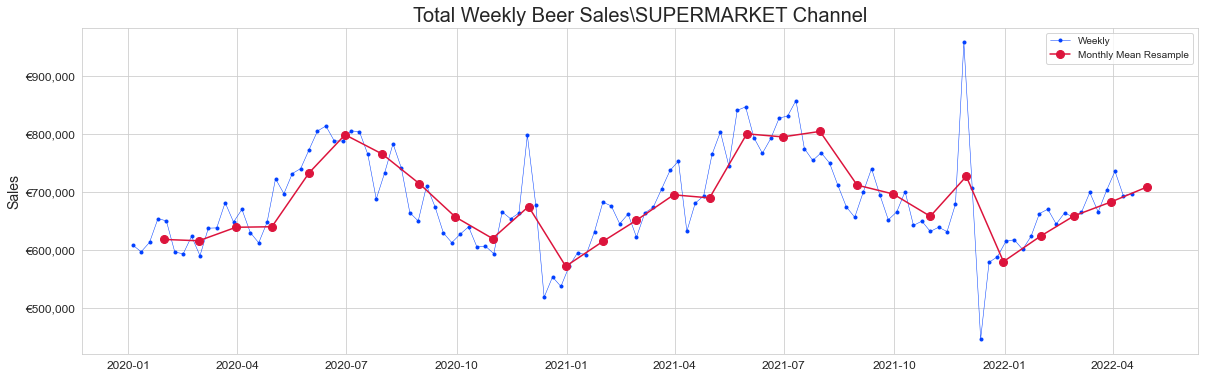

In [10]:
import seaborn as sns
sns.set_style("whitegrid")

import warnings
import matplotlib.pyplot as plt
y = df['sales_(€)']

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', 
        markersize=8, linestyle='-', 
        label='Monthly Mean Resample', 
        color='crimson')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_title("Total Weekly Beer Sales\SUPERMARKET Channel", fontsize=20)
ax.set_ylabel('Sales')
ax.legend();

## Decomposing the Data

In [11]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

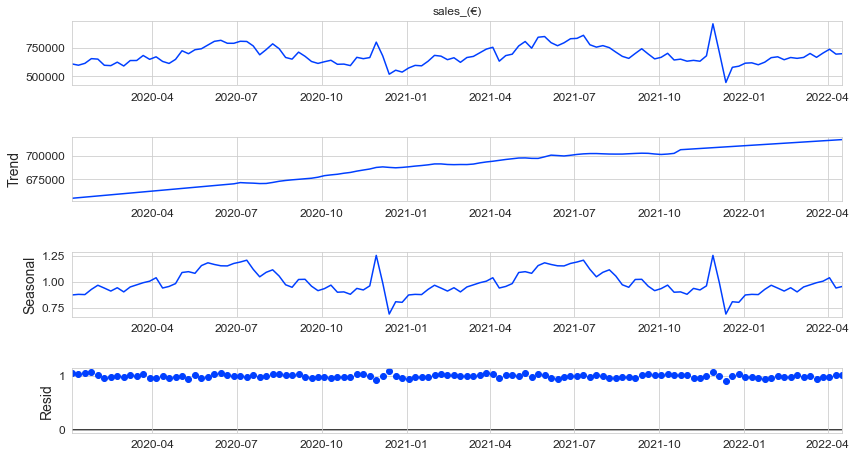

In [12]:
seasonal_decompose(y)

# Single HWES

In [13]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = "W"

# Set the value of Alpha and define m (Time Period)
m = 52
alpha = 1/(2*m)

#fitting the model
df['HWES1'] = SimpleExpSmoothing(df['sales_(€)']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

MAPE% on fitted values HW Single Exp Smoothing = 9.38%


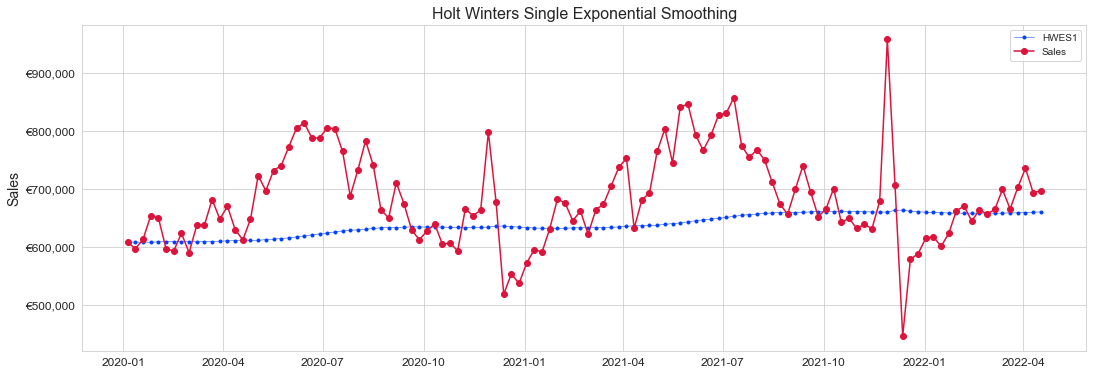

In [14]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES1'],marker='.', linestyle='-', linewidth=0.5, label='HWES1')
ax.plot(df['sales_(€)'],marker='o', markersize=6, linestyle='-', label='Sales', color='crimson')
ax.set_title(f"Holt Winters Single Exponential Smoothing", fontsize=16)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metric
mape_HWES1 = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES1'])*100, 2)

#printing evaluation metric
print(f'MAPE% on fitted values HW Single Exp Smoothing = {mape_HWES1}%')

# Double HWES

In [15]:
df['HWES2_ADD'] = ExponentialSmoothing(df['sales_(€)'],trend='add').fit().fittedvalues

df['HWES2_MUL'] = ExponentialSmoothing(df['sales_(€)'],trend='mul').fit().fittedvalues

df[['sales_(€)','HWES2_ADD','HWES2_MUL']]

,sales_(€),HWES2_ADD,HWES2_MUL
date,,,
2020-01-05,"608,279.65","615,458.53","615,458.53"
2020-01-12,"596,865.22","611,548.30","611,547.11"
2020-01-19,"613,169.27","603,354.48","603,350.30"
2020-01-26,"654,065.53","609,142.50","609,138.80"
2020-02-02,"649,895.36","634,969.86","634,974.30"
...,...,...,...
2022-03-20,"665,433.09","683,138.37","683,185.37"
2022-03-27,"702,481.47","673,224.52","673,271.63"
2022-04-03,"735,524.10","690,114.36","690,167.02"


MAPE% for fitted values HWS2_ADD = 5.75%
MAPE% for fitted values HWS2_MUL = 5.76%


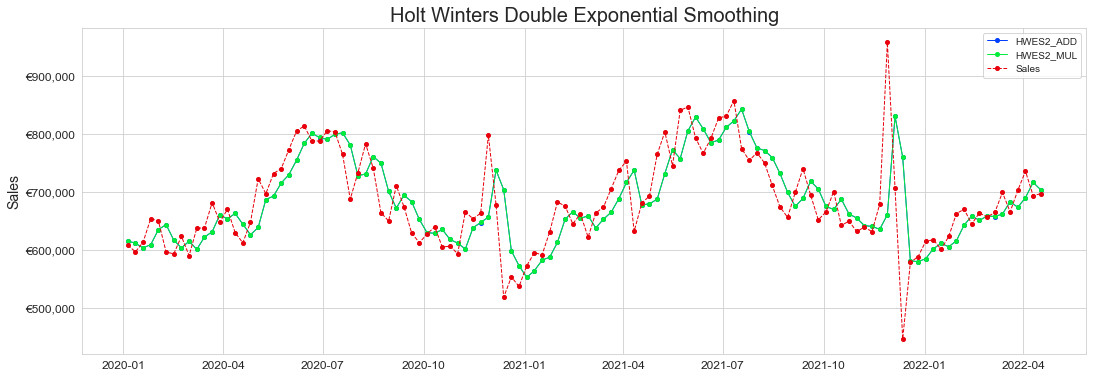

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES2_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_ADD')
ax.plot(df['HWES2_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales')
ax.set_title("Holt Winters Double Exponential Smoothing", fontsize=20)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metrics
mape_HWS2_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_ADD'])*100, 2)
mape_HWS2_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS2_ADD = {mape_HWS2_ADD}%')
print(f'MAPE% for fitted values HWS2_MUL = {mape_HWS2_MUL}%')

### Observations
Well, this looks a little better, but since we know there is Seasonality, we shall move into Triple ES and look at how it fits.

# Triple HWES

In [17]:
#Triple HWES helps us include a seasonal periods
#the seasonal parameter for out data is s=52 (the one attributed to data with weekly seasonality)

df['HWES3_ADD'] = ExponentialSmoothing(df['sales_(€)'], trend='add',seasonal='add',seasonal_periods=52).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(df['sales_(€)'], trend='mul',seasonal='mul',seasonal_periods=52).fit().fittedvalues

df[['HWES3_ADD', 'HWES3_MUL', 'sales_(€)']]

,HWES3_ADD,HWES3_MUL,sales_(€)
date,,,
2020-01-05,"553,029.02","556,431.76","608,279.65"
2020-01-12,"577,652.93","582,315.84","596,865.22"
2020-01-19,"574,358.98","579,462.07","613,169.27"
2020-01-26,"615,588.77","621,075.30","654,065.53"
2020-02-02,"667,516.91","673,340.91","649,895.36"
...,...,...,...
2022-03-20,"724,378.70","723,167.96","665,433.09"
2022-03-27,"747,376.70","742,838.92","702,481.47"
2022-04-03,"762,011.68","756,986.60","735,524.10"


MAPE% for fitted values HWS3_ADD = 2.86%
MAPE% for ftted values HWS3_MUL = 2.83%


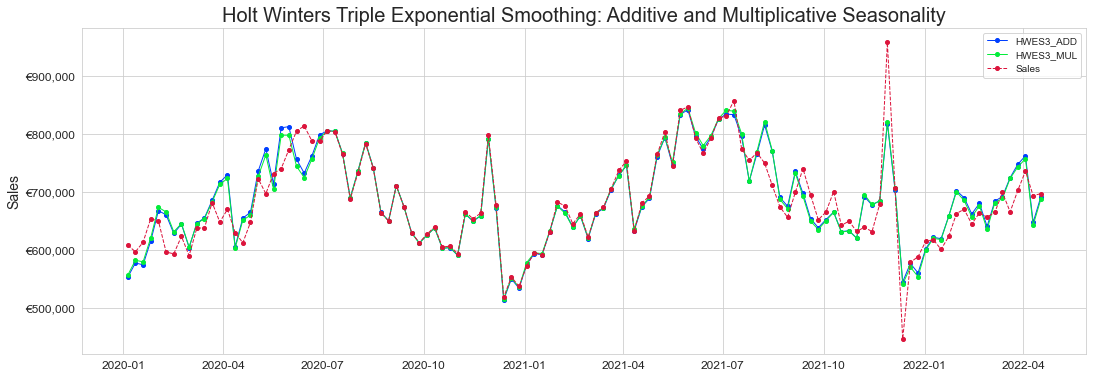

In [18]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES3_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_ADD')
ax.plot(df['HWES3_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales', color='crimson')
ax.set_title("Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality", fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_ylabel('Sales')

ax.legend();

#evaluation metrics
mape_HWS3_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_ADD'])*100, 2)
mape_HWS3_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS3_ADD = {mape_HWS3_ADD}%')
print(f'MAPE% for ftted values HWS3_MUL = {mape_HWS3_MUL}%')

# Splitting into Train & Test Set
Why are we sticking with HW Triple Exponential Smoothing?
Because according to the diagnostic plots made in the beginning we know there is Seasonality and a Trend and the MAPE% on fitted values for the `HW Triple ES` indicate the lowest proprotion of error, therefore, this model is the best option for us. 

In [39]:
forecast_data = data.copy() #making a copy of the original df

In [40]:
#SUPERMARKETs are signaled with a "1"
forecast_data = forecast_data[forecast_data.canal_code == 1]

#making sure that we are only handling the channel code "1"
forecast_data['canal_code'].unique()

array([1])

In [41]:
#converting to datetime index
forecast_data['date'] = pd.to_datetime(forecast_data['date'])

#groping by weekly total sales
forecast_data = forecast_data.groupby(['date'])['sales_(€)'].sum().to_frame()

In [42]:
#checking output
forecast_data.head()

,sales_(€)
date,
2020-01-05,"608,279.65"
2020-01-12,"596,865.22"
2020-01-19,"613,169.27"
2020-01-26,"654,065.53"
2020-02-02,"649,895.36"


In [43]:
#final df must have 120 rows of recorded data
forecast_data.shape

(120, 1)

In [44]:
#Let's split our data with the traditional 80/20 split
#Since we are dealing with time series data the order to the records must be kept intact

train = forecast_data[:105]  # taking 105 data points as train-set (2+ years in weekly sales format)
test = forecast_data[105:] # taking the last 15 data points as test-set 

In [45]:
#checking dates for train-set
print(train.index.min())
print(train.index.max())

2020-01-05 00:00:00
2022-01-02 00:00:00


In [46]:
#checking dates for test-set
print(test.index.min())
print(test.index.max())

2022-01-09 00:00:00
2022-04-17 00:00:00


In [47]:
#shapes must be 105 and 15 respectively
print(train.shape)
print(test.shape)

(105, 1)
(15, 1)


# Fitting the Models to the train data & making forecasts

In [48]:
#creating an empty container to score model evaluation metrics
model_metrics = []

In [49]:
#defining a function to change parameters easily and do a trial and error procedure
def HW_model(trend, seasonal, seasonal_periods, damped, title):
    
    fitted_model = ExponentialSmoothing(train['sales_(€)'],
                                    trend=trend,
                                    seasonal=seasonal,
                                    seasonal_periods=seasonal_periods,
                                    use_boxcox=True,
                                    damped=damped, 
                                    initialization_method="estimated").fit()

    test_predictions = fitted_model.forecast(15) 
    title=title
    
    #plotting
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(train['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Train')
    ax.plot(test['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=4, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title(f'{title}\nTrain, Test and Predicted Values\n Holt-Winters ({trend}-{seasonal}-seasonal-damped={damped})', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    plt.show()
    ax.legend();

    #zooming into test vs predicted
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test['sales_(€)'], marker='o', markersize=5, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=5, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title('Zooming in', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend();
    plt.show()

    #saving metrics in variables
    mae = mean_absolute_error(test,test_predictions)
    mse = mean_squared_error(test,test_predictions)
    mape = round(mean_absolute_percentage_error(test,test_predictions)*100, 2)
    rmse = mean_squared_error(test,test_predictions, squared=False)
    
    #printing evaluation metrics        
    print(f'Mean Absolute Error = {mae}')
    print(f'Mean Squared Error = {mse}')
    print(f'MAPE% = {mape}%')
    print(f'RMSE = {rmse}')

    #saving metrics for later comparison
    model_metrics.append({
            "model" : f'HW ({trend}-{seasonal}-seasonal-damped={damped})',
            "MAE" : mae,
            "MSE": mse, 
            "MAPE": f'{mape}%', 
            "RMSE": f'{rmse}'
    })

## Holt-Winters (add-add-seasonal)

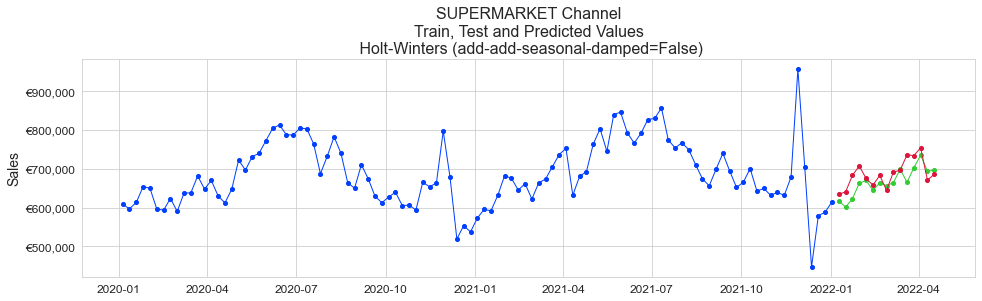

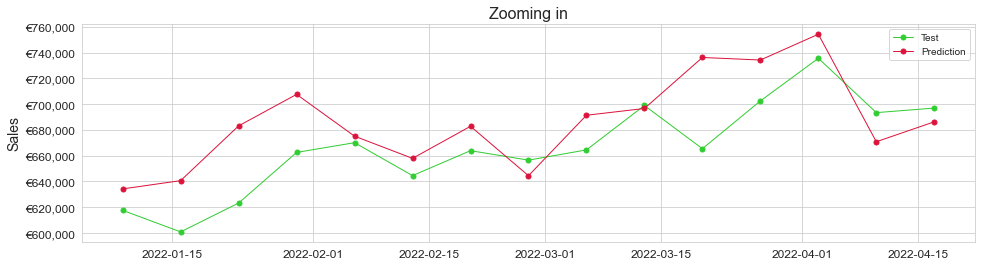

Mean Absolute Error = 26270.36418978983
Mean Squared Error = 1058220466.1058939
MAPE% = 4.0%
RMSE = 32530.30073801799


In [50]:
HW_model('add', 'add', 52, False, "SUPERMARKET Channel")

## Holt-Winters (add-add-seasonal-damped)

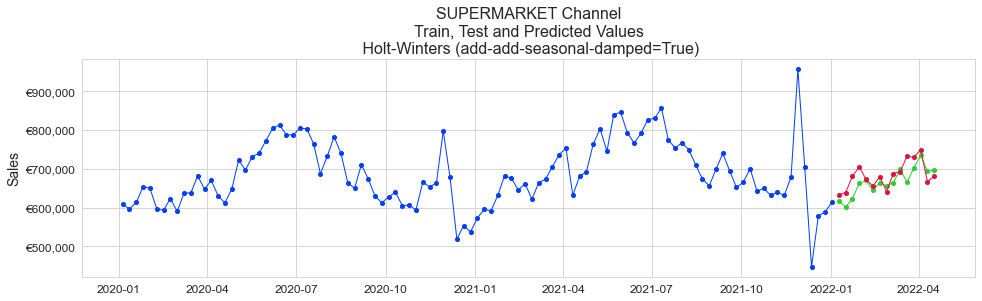

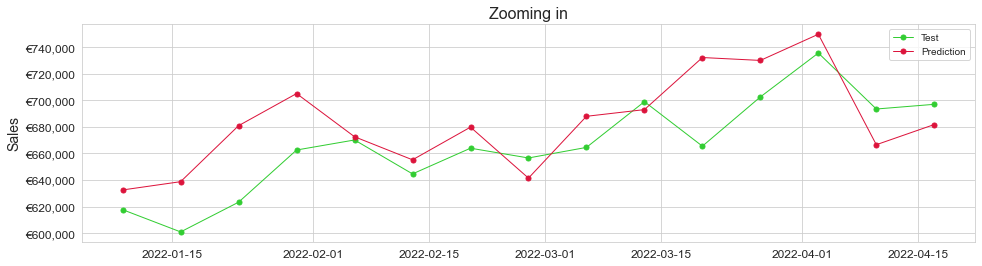

Mean Absolute Error = 25098.660066808643
Mean Squared Error = 953707137.4405988
MAPE% = 3.82%
RMSE = 30882.14917133519


In [51]:
HW_model('add', 'add', 52, True, 'SUPERMARKET Channel')

## Holt-Winters (add-mul-seasonal)

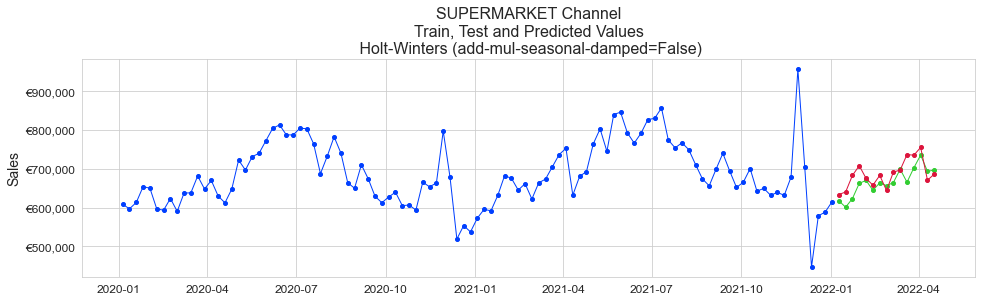

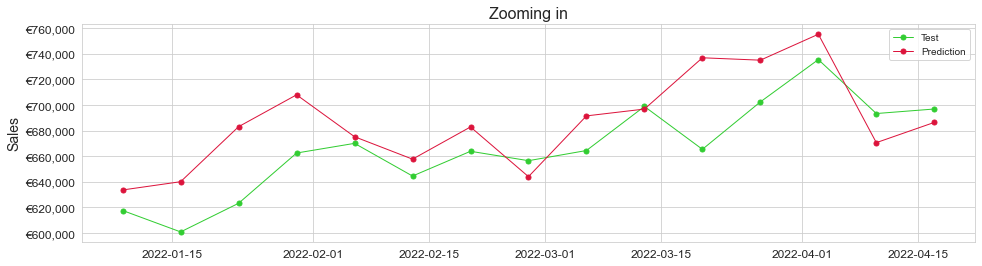

Mean Absolute Error = 26444.46714419186
Mean Squared Error = 1072907309.9661713
MAPE% = 4.03%
RMSE = 32755.263851267802


In [52]:
HW_model('add', 'mul', 52, False, 'SUPERMARKET Channel')

## Holt-Winters (add-mul-seasonal-damped)

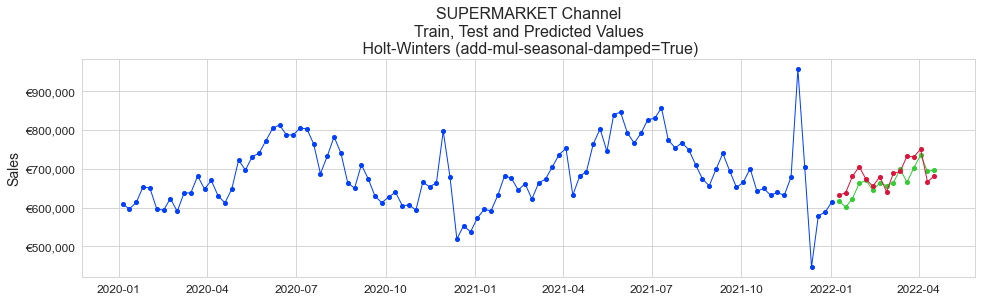

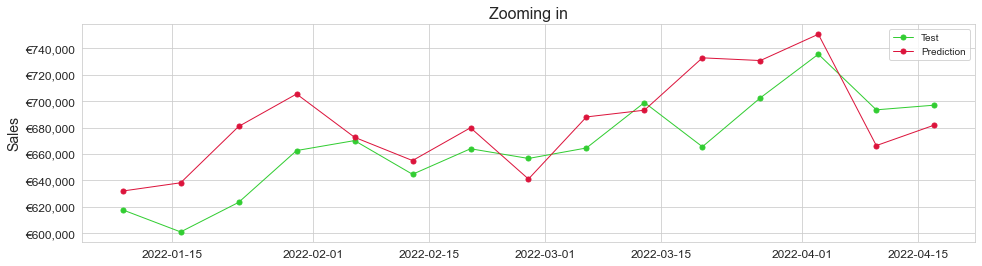

Mean Absolute Error = 25224.817066468553
Mean Squared Error = 963192594.919057
MAPE% = 3.84%
RMSE = 31035.34428549258


In [53]:
HW_model('add', 'mul', 52, True, "SUPERMARKET Channel")

# Model Comparison

In [54]:
model_metrics
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns = ["model", 
                                           'MSE',
                                           'MAE', 
                                           "MAPE", 
                                           "RMSE"]).set_index("model").sort_values(by=["MAPE"], ascending=True)
model_metrics_df  

,MSE,MAE,MAPE,RMSE
model,,,,
HW (add-add-seasonal-damped=True),"953,707,137.44","25,098.66",3.82%,30882.14917133519
HW (add-mul-seasonal-damped=True),"963,192,594.92","25,224.82",3.84%,31035.34428549258
HW (add-add-seasonal-damped=False),"1,058,220,466.11","26,270.36",4.0%,32530.30073801799
HW (add-mul-seasonal-damped=False),"1,072,907,309.97","26,444.47",4.03%,32755.263851267802


## The metric to that is going to decide the overall performance of the model is the MAPE%, this is how it should be interpreted:
* A `MAPE%` of `4.91%` implies the model is `95.09%` accurate in predicting the next 15 observations 

# Forecasting

In [59]:
#defining a function to make forecasts in any range of steps ahead
def final_HW_model(trend, seasonal, seasonal_periods, damped, steps_ahead, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, 
                            initialization_method="estimated").fit()
    
    simulations = fit.simulate(steps_ahead, repetitions=100, error="add")
    
    ax = forecast_data.plot(figsize=(18, 6), marker="o", markersize=4, lw=1)
    ax.set_title(f"Forecast and Simulation for {title}\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})", fontsize=18)
    ax.set_ylabel("Sales")
    ax.set_xlabel(" ")
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))
           
    fit.fittedvalues.plot(ax=ax, style="--", markersize=3, color="crimson", label='Fitted Values',  legend=True)
    simulations.plot(ax=ax, style="-", alpha=0.05, color="orange", legend=False)
    fit.forecast(steps_ahead).rename(f"Train, Test and Predicted Test\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})").plot(
    ax=ax, style="-", marker="o", markersize=4,  color="crimson", lw=1, legend=True, label='Predictions')
    
    # Annotate
    x_line_annotation = '2022-4-1'
    x_text_annotation = '2022-4-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='b')
    ax.text(x=x_text_annotation, y=950000, s='2022Q2', color='b')
    
    x_line_annotation = '2022-07-1'
    x_text_annotation = '2022-07-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='g')
    ax.text(x=x_text_annotation, y=950000, s='2022Q3', color='g')

    x_line_annotation = '2022-10-1'
    x_text_annotation = '2022-10-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='r')
    ax.text(x=x_text_annotation, y=950000, s='2022Q4', color='r')
    plt.axvline(x='2022-12-31', color='r', linestyle='dashed')
    
    x_line_annotation = '2023-01-01'
    x_text_annotation = '2023-01-01'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='orangered')
    ax.text(x=x_text_annotation, y=950000, s='FY-2023', color='orangered')
    plt.axvline(x='2023-12-31', color='orangered', linestyle='dashed')
    
    return plt.show()

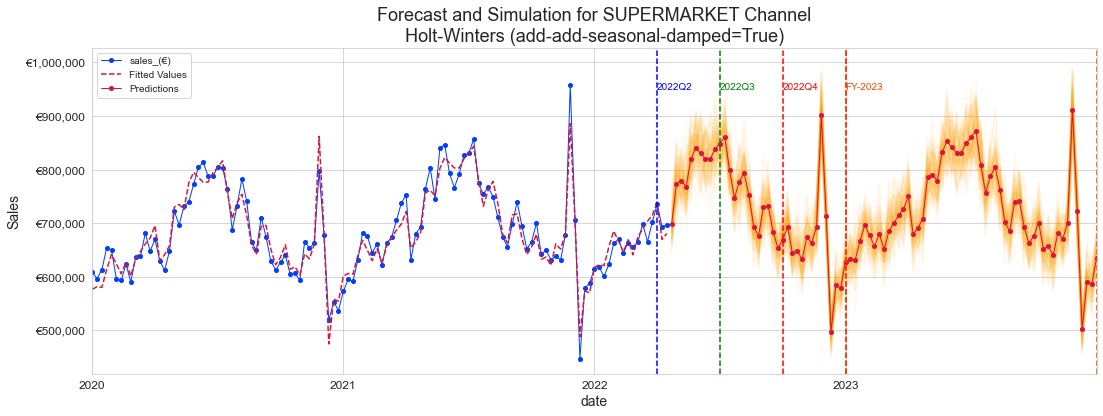

In [60]:
#why are we choosing 89 steps ahead?
    #because those the total steps ahead necessary to do the forecast until the end of FY-2023
final_HW_model('add', 'add', 52, True, 89, 'SUPERMARKET Channel') 

In [62]:
#defining a function to make forecasts in any range of steps ahead
def forecast_euro_value_until_2023(trend, seasonal, seasonal_periods, damped, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    title = title
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, 
                            initialization_method="estimated").fit()


    #making the forecast and putting values in inside a dataframe
    forecast = fit.forecast(89).to_frame().reset_index()

    #rename columns for more readability
    forecast.rename(columns={0: title, 'index': 'date'} ,inplace=True)

    #convert date column to datetime object
    forecast['date'] = pd.to_datetime(forecast['date'])

    #group by quarterly total sales
    return print(forecast.groupby(forecast['date'].dt.to_period('Q'))[title].sum().to_frame()), print(forecast.groupby(forecast['date'].dt.to_period('Y'))[title].sum().to_frame())

In [63]:
#defining a function to input the parameters of the best model and getting predictions in euro value
forecast_euro_value_until_2023('add', 'add', 52, True, "SUPERMARKET_channel_sales")

        SUPERMARKET_channel_sales
date                             
2022Q2               7,989,428.96
2022Q3               9,747,997.30
2022Q4               8,593,696.24
2023Q1               8,748,332.65
2023Q2              10,224,606.04
2023Q3               9,874,758.98
2023Q4               9,329,742.20
      SUPERMARKET_channel_sales
date                           
2022              26,331,122.50
2023              38,177,439.88


(None, None)